# <center>Cross Validation &amp; Ensembling</center>
<center>Shan-Hung Wu &amp; DataLab<br/>Fall 2021</center>

In [1]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.6.8
import os, itertools, csv

from IPython.display import Image
from IPython.display import display

# numpy  1.19.5
import numpy as np

# pandas  0.25.3
import pandas as pd

# scikit-learn  0.22
from sklearn import datasets
load_iris = datasets.load_iris
make_moons = datasets.make_moons
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier

# matplotlib  3.1.2
import matplotlib.pyplot as plt

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
from lib import *

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")

In this lab, we will guide you through the **cross validation** technique for hyperparameter selection. We will also practice the **ensemble learning** techniques that combine multiple base-leaners for better performance.

## Holdout Method

So far, we hold out the validation and testing sets for hyperparameter tuning and performance reporting. Specifically, we partition a dataset $\mathbb{X}$ into the training, validation, and testing sets. We use the training set to fit a model by giving a set of hyperparameters, and then use the validation set to evaluate the performance of the model given the hyperparameters. We repeat these two steps by issuing different sets of hyperparameters and pick the set that leads to the highest validation performance. We then use **both the training and validation sets** to train our final model, and apply it the testing set to evaluate/report the generalization performance. The following figure illustrates the procedure:

<img src="fig-holdout.png" width="500">

Next, we apply this technique to evaluate the `KNeighborsClassifier` on the Iris dataset. For simplicity, we consider the `sepal width` and `petal length` features only. Let's split the dataset first:

In [2]:
iris = load_iris()
X, y = iris.data[:,[1,2]], iris.target

# hold out testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# hold out validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

Then, we iterate through each value of hyperparameter `n_neighbors` = 1, 15, 50 to train on the training set and estimate performance on the validation set and record the best:

In [3]:
best_k, best_score = -1, -1
clfs = {}

# hyperparameter tuning
for k in [1, 15, 50]: 
    pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors=k)]])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    print('[{}-NN]\nValidation accuracy: {}'.format(k, score))
    if score > best_score:
        best_k, best_score = k, score
    clfs[k] = pipe
    
# performance reporting
y_pred= clfs[best_k].predict(X_test)
print('\nTest accuracy: %.2f (n_neighbors=%d selected by the holdout method)' % 
      (accuracy_score(y_test, y_pred), best_k))

[1-NN]
Validation accuracy: 0.9375
[15-NN]
Validation accuracy: 0.90625
[50-NN]
Validation accuracy: 0.4375

Test accuracy: 0.89 (n_neighbors=1 selected by the holdout method)


One major disadvantage of the holdout method is that the validation and testing performance is **sensitive to the random splits**. If we have a unfortunate split such that the validation (resp. testing) set is unrepresentative, we may end up picking suboptimal hyperparameters (resp. reporting a misleading performance score).

In this case, the hyperparameter `n_neighbors` = 15 actually leads to better test performance:

In [4]:
y_pred= clfs[15].predict(X_test)
print('Test accuracy: %.2f (n_neighbors=15 selected manually)' % 
      accuracy_score(y_test, y_pred))

Test accuracy: 0.91 (n_neighbors=15 selected manually)


We can see that the validation set is unrepresentative and leads to indistinguishable validation accuracy scores (1.0) for all values of `n_neighbors`.


Next, we take a look at a more robust technique called the **$K$-Fold Cross-Validation**.


## $K$-Fold Cross Validation

In $K$-fold cross-validation (CV), we randomly split the training dataset into $K$ folds without replacement, where $K−1$ folds are used for the model training and the remaining 1 fold is for testing. This procedure is repeated $K$ times so that we obtain $K$ models and $K$ performance estimates. Then we take their **average** as the final performance estimate. The following figure illustrate the 10-fold CV:

<img src="fig-kfold.png" width="600">

We can apply $K$-fold CV to either the hyperparameter tuning, performance reporting, or both. The advantage of this approach is that the performance is less sensitive to unfortunate splits of data. In addition, it utilize data better since each example can be used for both training and validation/testing.

Let's use $K$-Fold CV to select the hyperparamter `n_neighbors` of the `KNeighborsClassifier`:

In [5]:
iris = load_iris()
X, y = iris.data[:,[1,2]], iris.target

# hold out testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

The dataset is first split into training/testing sets.

In [6]:
best_k, best_score = -1, -1
clfs = {}

for k in [1, 15, 50]: # experiment different hyperparameter
    pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors=k)]])
    pipe.fit(X_train, y_train)
    # K-Fold CV
    scores = cross_val_score(pipe, X_train, y_train, cv=5)
    print('[%d-NN]\nValidation accuracy: %.3f %s' % (k, scores.mean(), scores))
    if scores.mean() > best_score:
        best_k, best_score = k, scores.mean()
    clfs[k] = pipe

[1-NN]
Validation accuracy: 0.895 [0.9047619  0.95238095 0.85714286 0.85714286 0.9047619 ]
[15-NN]
Validation accuracy: 0.895 [0.9047619  0.85714286 0.9047619  0.9047619  0.9047619 ]
[50-NN]
Validation accuracy: 0.819 [0.80952381 0.80952381 0.85714286 0.80952381 0.80952381]


5-fold CV selects the best `n_neighbors` = 15 as we expected. Once selecting proper hyperparameter values, we retrain the model on the **complete training set** and obtain a final performance estimate on the test set:

In [7]:
best_clf = clfs[best_k]
best_clf.fit(X_train, y_train)

# performance reporting
y_pred = best_clf.predict(X_test)
print('Test accuracy: %.2f (n_neighbors=%d selected by 5-fold CV)' % 
      (accuracy_score(y_test, y_pred), best_k))

Test accuracy: 0.84 (n_neighbors=1 selected by 5-fold CV)


### Nested CV

We can also apply the $K$-fold CV to both the hyperparameter selection and performance reporting at the same time, this is called the **nested CV**. Following illustrate the $5\times 2$ nested CV:

<img src="fig-nestedcv.png" width="500">

where we select the values of hyperparameters by 2-fold CV and estimate the generalized performance by 5-fold CV, respectively. Let's try this ourselves:

In [8]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)): 
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    best_k, best_score = -1, -1
    clfs = {}
    # hyperparameter tuning 
    for k in [1, 15, 50]:
        inner_scores = []
        # inner folds
        for itrain_idx, val_idx in inner_cv.split(X_train, y_train):
            X_itrain, X_val = X_train[itrain_idx], X_train[val_idx]
            y_itrain, y_val = y_train[itrain_idx], y_train[val_idx]
            
            pipe = Pipeline([['sc', StandardScaler()],
                             ['clf', KNeighborsClassifier(n_neighbors=k)]])
            pipe.fit(X_itrain, y_itrain)
            
            y_pred = pipe.predict(X_val)
            inner_scores.append(accuracy_score(y_val, y_pred))
        score_mean = np.mean(inner_scores)
        if best_score < score_mean:
            best_k, best_score = k, score_mean
        clfs[k] = pipe
        
    # evaluate performance on test fold
    best_clf = clfs[best_k]
    best_clf.fit(X_train, y_train)    
    y_pred = best_clf.predict(X_test)
    outer_scores.append(accuracy_score(y_test, y_pred))
    print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], best_k))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.90 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.90 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.90 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.93 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 1.00 (n_neighbors=15 selected by inner 10-fold CV)

Test accuracy: 0.93 (5x10 nested CV)


As we can see, the 5 inner CVs may select different values for the hyperparameter `n_neighbors`. In this case, the 1st inner CV selects `n_neighbors` = 1 due to an unlucky split of the training and testing sets in the outer fold. By doing nested CV, we get a more robust performance estimation.

In fact, we can simplify the above example using the `GridSearchCV` from Scikit-learn:

In [9]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier()]])
    # hyperparameter tuning by grid search CV
    param_grid = {'clf__n_neighbors':[1, 15, 50]}
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid, 
                      scoring='accuracy', cv=inner_cv)
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_
    best_clf.fit(X_train, y_train)    
    outer_scores.append(best_clf.score(X_test, y_test))
    print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], gs.best_params_['clf__n_neighbors']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.90 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.90 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.90 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.93 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 1.00 (n_neighbors=15 selected by inner 10-fold CV)

Test accuracy: 0.93 (5x10 nested CV)


NOTE: if we have a dataset with imbalance classes, we should use the **stratified** $K$-fold CV that prepserves the class proportions in each fold to ensure that each fold is representative of the class proportions in the training dataset. To use stratified CV, simply replace

```
>>> from sklearn.model_selection import KFold
>>> KFold(n_splits=...)
```

with

```
>>> from sklearn.model_selection import StratifiedKFold
>>> StratifiedKFold(y=..., n_splits=...)
```

### How Many Folds?

How many folds $K$ do we need? Here are some rules of thumb explained in the lecture:

* For large $K$, the MSE of cross-validation error (to the true expected generalization error of $f_N$) tends to have a small bias but large variance since a classifier in each iteration is trained on more examples but classifiers from different folds are trained on similar examples; 
* On the other hand, for small $K$, the cross-validation error tends to have large bias but small variance;
* When dataset is small, the cross-validation error will have both large bias and large variance.

To see these in practice, let's consider the Polynomial regression where the ground truth data generating distribution is known: 

$$\mathrm{P}(\mathrm{y}|\mathrm{x}) = \sin(x) + \epsilon, \epsilon\sim\mathcal{N}(0,\sigma^2)$$

We can visualize the bias and variance as follows:

In [10]:
sigma = 1
n_range = range(10, 50, 2)
k_range = [5, 10]

poly = PolynomialFeatures(degree=2)
X = np.array([])
y = np.array([])
cv5_mean = []
cv5_std = []
cv10_mean = []
cv10_std = []
exp_mean = []
for n in n_range:
    # compute the bias and variance of cv5
    mse_test = []
    for i in range(500):
        x, y = gen_data(n, sigma)
        X = poly.fit_transform(x[:, np.newaxis])
        
        cv5 = KFold(n_splits=5, random_state=1)
        for i, (train, test) in enumerate(cv5.split(X, y)):
            lr = LinearRegression()
            lr.fit(X[train], y[train])
            y_test_pred = lr.predict(X[test])
            mse_test.append(mean_squared_error(y[test], y_test_pred))
    
    cv5_mean.append(np.mean(mse_test))
    cv5_std.append(np.std(mse_test))
    
    # compute the bias and variance of cv10
    mse_test = []
    for i in range(500):
        x, y = gen_data(n, sigma)
        X = poly.fit_transform(x[:, np.newaxis])
        
        cv10 = KFold(n_splits=10, random_state=1)
        for i, (train, test) in enumerate(cv10.split(X, y)):
            lr = LinearRegression()
            lr.fit(X[train], y[train])
            y_test_pred = lr.predict(X[test])
            mse_test.append(mean_squared_error(y[test], y_test_pred))
    
    cv10_mean.append(np.mean(mse_test))
    cv10_std.append(np.std(mse_test))
    
    # compute the expected generalization error of f_N
    mse_test = []
    for i in range(500):
        x, y = gen_data(n, sigma)
        X = poly.fit_transform(x[:, np.newaxis])
        lr = LinearRegression()
        lr.fit(X, y)
        x_test, y_test = gen_data(100, sigma)
        X_test = poly.transform(x_test[:, np.newaxis])
        y_test_pred = lr.predict(X_test)
        mse_test.append(mean_squared_error(y_test, y_test_pred))
    exp_mean.append(np.mean(mse_test))

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/nthudatalab1/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

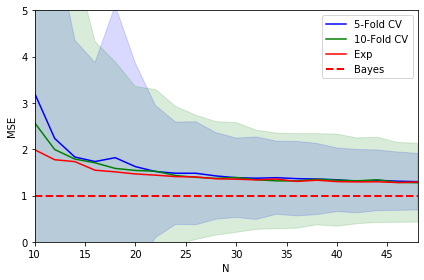

In [11]:
plt.plot(n_range, cv5_mean, 
         markersize=5, label='5-Fold CV', color='blue')
plt.fill_between(n_range,
                 np.add(cv5_mean, cv5_std),
                 np.subtract(cv5_mean, cv5_std),
                 alpha=0.15, color='blue')

plt.plot(n_range, cv10_mean, 
         markersize=5, label='10-Fold CV', color='green')
plt.fill_between(n_range,
                 np.add(cv10_mean, cv10_std),
                 np.subtract(cv10_mean, cv10_std),
                 alpha=0.15, color='green')

plt.plot(n_range, exp_mean, 
         markersize=5, label='Exp', color='red')

plt.hlines(y=sigma, xmin=10, xmax=48, 
           label='Bayes', color='red', 
           linewidth=2, linestyle='--')

plt.legend(loc='upper right')
plt.xlim([10, 48])
plt.ylim([0, 5])
plt.xlabel('N')
plt.ylabel('MSE')
plt.tight_layout()
plt.savefig('./output/fig-cv-fold.png', dpi=300)
plt.show()

Usually, we set $K=10$ in most applications, $K=5$ for larger datasets, and $K=N$ for very small datasets. The last setting is called the **leave-one-out CV**.

## Ensemble Methods

No free lunch theorem states that no machine learning algorithm is universally better than others in all domains. The goal of ensembling is to combine multiple learners to improve the applicability and get better performance. 

NOTE: it is possible that the final model performs no better than the most accurate learner in the ensemble models. But it at least reduces the probability of selecting a poor one and increases the applicability. 

### Voting

Voting is arguably the most straightforward way to combine multiple learners $d^{(j)}(\cdot)$. The idea is to taking a linear combination of the predictions made by the learners. For example, in multiclass classification, we have

$$\tilde{y}_k =\sum_j^L w_j d^{(j)}_k(\boldsymbol{x}), \text{ where }w_j\geq 0\text{ and }\sum_j w_j=1,$$

for any class $k$, where $L$ is the number of voters. This can be simplified to the **plurarity vote** where each voter has the same weight:

$$\tilde{y}_k =\sum_j \frac{1}{L} d^{(j)}_k(\boldsymbol{x}).$$

Let's use the `VotingClassifier` from Scikit-learn to combine `KNeighborsClassifer`, `LogisticRegression`, and `DecisionTreeClassifier` together and train on the synthetic two-moon dataset:

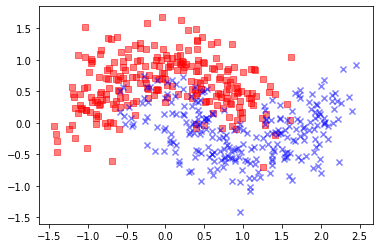

In [12]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Class 0',
            c='r', marker='s', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='Class 1',
            c='b', marker='x', alpha=0.5)
plt.scatter(X_test[:, 0], X_test[:, 1],
            c='', marker='o', label='Class 1')
plt.show()

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(C = 10, random_state = 0, solver = "liblinear")]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(max_depth = 3, random_state = 0)]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors = 5)]])

We can estimate the performance of individual classifiers via the 10-fold CV:

In [13]:
clf_labels = ['LogisticRegression', 'DecisionTree', 'KNN']
print('[Individual]')
for pipe, label in zip([pipe1, pipe2, pipe3], clf_labels):
    scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('%s: %.3f (+/- %.3f)' % (label, scores.mean(), scores.std()))

[Individual]
LogisticRegression: 0.932 (+/- 0.026)
DecisionTree: 0.943 (+/- 0.026)
KNN: 0.952 (+/- 0.023)


Let's combined the classifiers by `VotingClassifer` from Scikit-learn and experiment some weight combinations:

In [14]:
print('[Voting]')
best_vt, best_w, best_score = None, (), -1
for a, b, c in list(itertools.permutations(range(0,3))): # try some weight combination
    clf = VotingClassifier(estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3)], 
                           voting='soft', weights=[a,b,c])
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('%s: %.3f (+/- %.3f)' % ((a,b,c), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt, best_w, best_score = clf, (a, b, c), scores.mean()

print('\nBest %s: %.3f' % (best_w, best_score))

[Voting]
(0, 1, 2): 0.962 (+/- 0.019)
(0, 2, 1): 0.964 (+/- 0.018)
(1, 0, 2): 0.961 (+/- 0.020)
(1, 2, 0): 0.947 (+/- 0.026)
(2, 0, 1): 0.951 (+/- 0.019)
(2, 1, 0): 0.943 (+/- 0.023)

Best (0, 2, 1): 0.964


The best ensemble combines the `DecisionTreeClassifier` and `KNeighborsClassifier`. This is a reasonable choice because these two models "complement" each other in design: `DecisionTreeClassifier` makes predictions based on informative **features**; while `KNeighborsClassifier` makes predictions based on representative **examples**. 

To compare the `VotingClassifer` with individual classifiers on the testing set, we can plot the ROC curves:

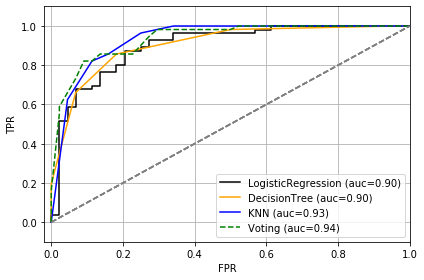

In [15]:
clf_labels =['LogisticRegression', 'DecisionTree', 'KNN', 'Voting']
colors = ['black', 'orange', 'blue', 'green']
linestyles = ['-', '-', '-', '--']
for clf, label, clr, ls in zip([pipe1, pipe2, pipe3, best_vt], clf_labels, colors, linestyles):
    # assume positive class is at dimension 2
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc=%0.2f)' % (label, roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlim([-0.02, 1])
    plt.ylim([-0.1, 1.1])
    plt.grid()
    plt.xlabel('FPR')
    plt.ylabel('TPR')

plt.grid()
plt.tight_layout()
plt.savefig('./output/fig-vote-roc.png', dpi=300)
plt.show()

As we can see, the `VotingClassifer` can successfully combine the base-learners to give a higher true-positive rate at a low false-positive rate. Let's see the decision boundaries:

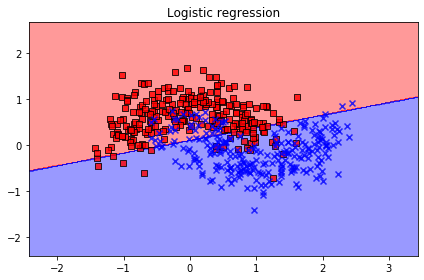

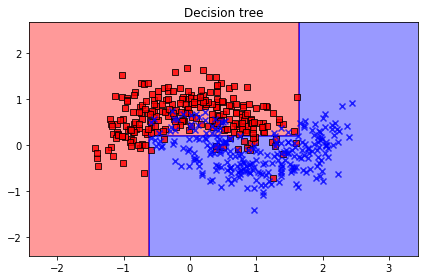

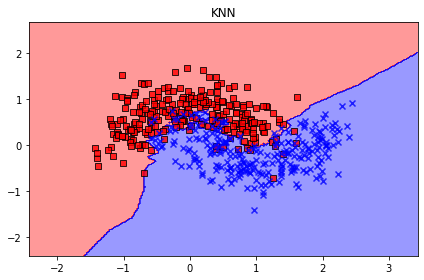

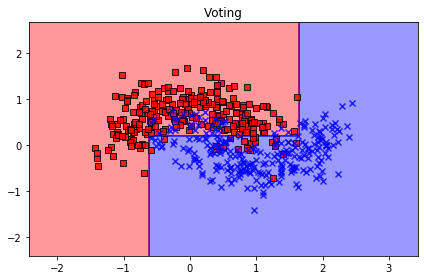

In [16]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=pipe1,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Logistic regression')
plt.tight_layout()
plt.savefig('./output/fig-vote-logistic-regressio-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=pipe2,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.savefig('./output/fig-vote-decision-tree-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=pipe3,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('KNN')
plt.tight_layout()
plt.savefig('./output/fig-voting-knn-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=best_vt,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Voting')
plt.tight_layout()
plt.savefig('./output/fig-voting-boundary.png', dpi=300)
plt.show()


The decision boundaries of `DecisionTreeClassifier` and `VotingClassifier` looks similar. But they have different **soft** decision boundaries that take into account the probability/confidence of predictions:

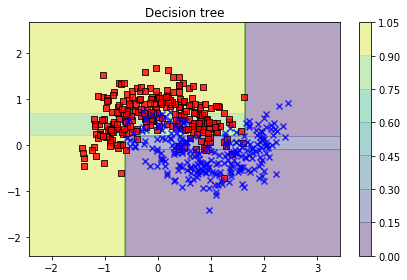

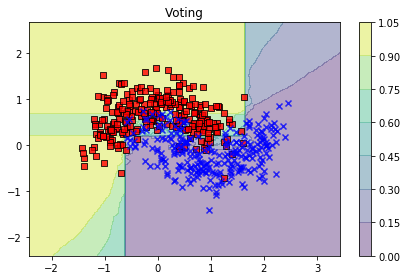

In [17]:
plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=pipe2, soft=True,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.savefig('./output/fig-vote-decision-tree-boundary-soft.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=best_vt, soft=True,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Voting')
plt.tight_layout()
plt.savefig('./output/fig-voting-boundary-soft.png', dpi=300)
plt.show()

The different soft decision boundaries result in different ROC curves.

NOTE: here we extend the `plot_decision_regions()` function such that it draws a "soft" decision boundary of a binary classifier (using the `predict_proba()` method, if existing) when fed by a parameter `soft=True`. Please refer to the `lib.py` for more details.

### Bagging

**Bagging** (Bootstrap AGgragating) is a voting method where each base-learner are trained over a slightly different training set. The procedure of bagging is summarized below:

1. Train $L$ classifiers, each on a dataset generated by **bootstrapping** (draw with replacement);
2. Predict by voting (aggregating all predictions of the $L$ classifiers).

Bagging can reduce the **variance** since voters now only see different training sets and become less positively correlated with each other. Also, bagging is more robust to noise and outliers since we do the resampling on dataset. However, the model **bias** cannot be reduced, and this is why we usually use classifiers with low bias, for example, decision trees or nonlinear SVMs, as the base-learners in bagging.

NOTE: when the amount of data is large enough, bagging doesn't help since each classifier will have low variance. We can introduce additional diversity to bagging by **randomly selecting features** of training examples. The random forest model is this kind of ensembling of decision trees.

The `BaggingClassifier` is provided by Scikit-learn. Let's use the unpruned `DecisionTreeClassifier` as the base-learner and create an ensemble of 500 decision trees fitted on different bootstrap examples of the training set:

In [18]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

The parameter `max_samples` controls the number of bootstrapped examples and `max_feature` controls the proportion of features from the feature set that will be sampled to train the base classifiers. We disable feature bootstrapping here.

Next, we compare the performance of the trained `BaggingClassifier` to a single unpruned `DecisionTreeClassifier`:

In [19]:
# single DecisionTree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, tree_test))
# Bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging] accuracy-train = %.3f, accuracy-test = %.3f' % (bag_train, bag_test))

[DecisionTree] accuracy-train = 1.000, accuracy-test = 0.840
[Bagging] accuracy-train = 0.993, accuracy-test = 0.860


We sample $0.7N$ examples in each bootstrap to make the base-learners more uncorrelated. The `BaggingClassifer` successfully mitigates the overfitting behavior of the unpruned `DecisionTreeClassifier` and gives better generalization performance. We can see this more clearly by comparing the decision boundaries of the two models:

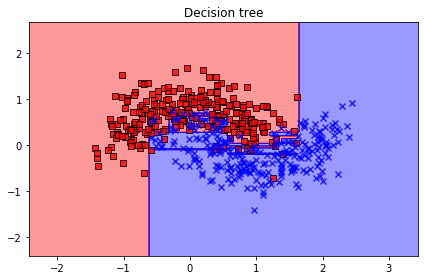

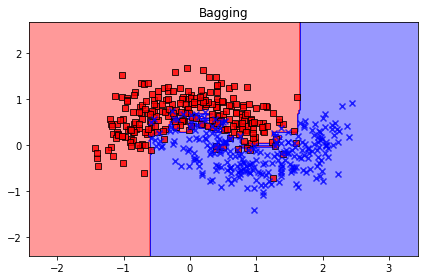

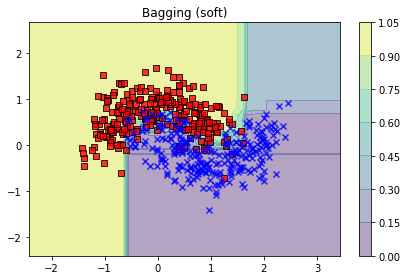

In [20]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=tree,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.savefig('./output/fig-bagging-decision-tree-boundary.png', dpi=300)
plt.show()


plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=bag, 
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Bagging')
plt.tight_layout()
plt.savefig('./output/fig-bagging-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=bag, soft=True,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Bagging (soft)')
plt.tight_layout()
plt.savefig('./output/fig-bagging-boundary-soft.png', dpi=300)
plt.show()

The BaggingClassifer give a smoother decision boundary that less overfits the training data.

### Boosting

The key idea of **boosting** is to create **complementary** base-leanrers by training the new learner using the examples that the previous leaners do not agree. A common implementation is **AdaBoost** (Adaptive Boosting), which can be summarized as followings:

1. Initialize $\Pr^{(i,1)}=\frac{1}{N}$ for all $i$;
2. Start from $j=1$:
    1. Randomly draw $\mathbb{X}^{(j)}$ from $\mathbb{X}$ with probabilities $\Pr^{(i,j)}$ and train $d^{(j)}$;
    2. Stop adding new base-learners if $\epsilon^{(j)}=\sum_{i}\Pr^{(i,j)}1(y^{(i)}\neq d^{(j)}(\boldsymbol{x}^{(i)}))\geq\frac{1}{2}$;
    3. Define $\alpha_{j}=\frac{1}{2}\log\left(\frac{1-\varepsilon^{(j)}}{\varepsilon^{(j)}}\right)>0$ and set $\Pr^{(i,j+1)}=\Pr^{(i,j)}\cdot\exp(-\alpha_{j}y^{(i)}d^{(j)}(\boldsymbol{x}^{(i)}))$ for all $i$;

After training, the (soft) prediction $\tilde{y}$ is made by voting: $\tilde{y}=\sum_{j}\alpha_{j}d^{(j)}(\boldsymbol{x})$. 

Let's train an `AdaBoostClassifier` from Scikit-learn with 500 decision trees of depth 1:

In [21]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
# single decision tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (tree_train, tree_test))

# adaboost
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))

[DecisionTree] accuracy-train = 0.838, accuracy-test = 0.710
[AdaBoost] accuracy-train = 1.000, accuracy-test = 0.870


The `AdaBoostClassifier` predicts all training examples correctly but not so well on testing set, which is a sign of overfitting. However, since `AdaBoostClassifier` increases the **margins** of training examples (as discussed in the lecture), the variance can be controlled. Overall, `AdaBoostClassifier` gives better generalization performance due to a smaller bias.

Let's check the decision boundaries:

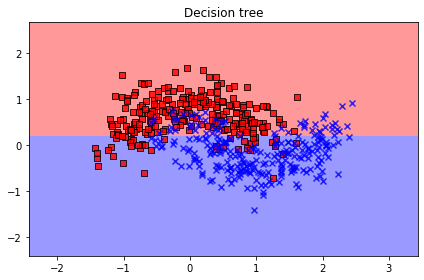

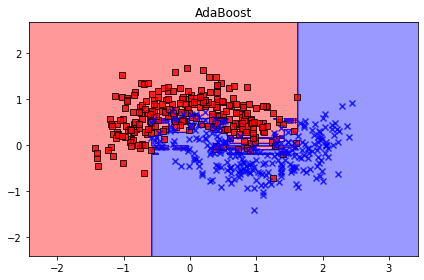

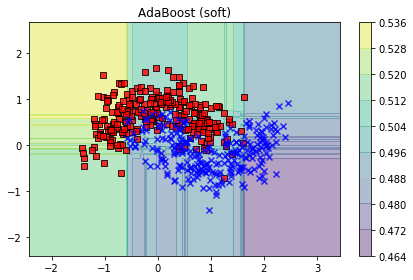

In [22]:
plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=tree,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=ada,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('AdaBoost')
plt.tight_layout()
plt.savefig('./output/fig-adaboost-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=ada, soft=True,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('AdaBoost (soft)')
plt.tight_layout()
plt.savefig('./output/fig-adaboost-boundary-soft.png', dpi=300)
plt.show()

We can see that the decision boundary of `AdaBoostClassifier` is substantially more complex than the depth-1 decision tree.

Next, let see how the performance `AdaBoostClassifier` changes as we add more weak learners:

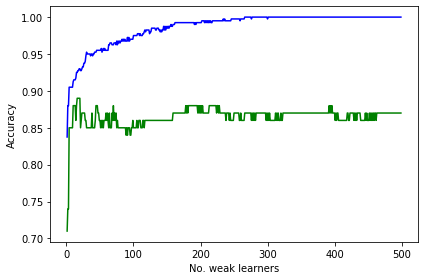

In [23]:
range_est = range(1, 500)
ada_train, ada_test = [], []
for i in range_est:
    ada = AdaBoostClassifier(base_estimator=tree, n_estimators=i, 
                             learning_rate=1, random_state=1)
    ada = ada.fit(X_train, y_train)
    y_train_pred = ada.predict(X_train)
    y_test_pred = ada.predict(X_test)

    ada_train.append(accuracy_score(y_train, y_train_pred))
    ada_test.append(accuracy_score(y_test, y_test_pred))
        
plt.plot(range_est, ada_train, color='blue')
plt.plot(range_est, ada_test, color='green')
plt.xlabel('No. weak learners')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('./output/fig-adaboost-acc.png', dpi=300)
plt.show()

As we add more and more weak learners, the model complexity increases and the test accuracy first goes up due to the reduced bias. Then it goes down due to the increased variance. However, the variance does not continue to grow as we add more weak learners thanks to the enlarged margins of training examples. 

The above examples show that the `AdaBoostClassifier` **can overfit**. Also, if the dataset contains outliers or is noisy, AdaBoost will try to fit those "hard" but bad examples. We should be careful about overfitting when applying AdaBoost in practice. In this case, we can get a smoother decision boundary if we stop at $L=16$:

[AdaBoost16] accuracy-train = 0.925, accuracy-test = 0.890


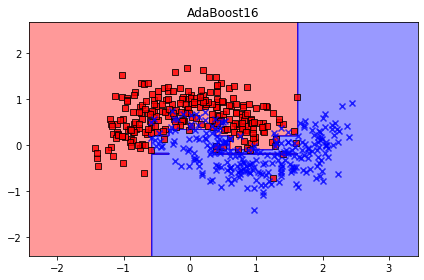

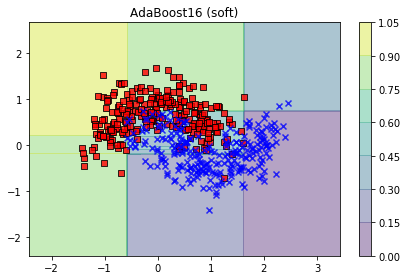

In [24]:
ada16 = AdaBoostClassifier(base_estimator=tree, n_estimators=16)
ada16.fit(X_train, y_train)
y_train_pred = ada16.predict(X_train)
y_test_pred = ada16.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost16] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=ada16,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('AdaBoost16')
plt.tight_layout()
plt.savefig('./output/fig-adaboost16-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=ada16, soft=True,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('AdaBoost16 (soft)')
plt.tight_layout()
plt.savefig('./output/fig-adaboost16-boundary-soft.png', dpi=300)
plt.show()

Finally, let's compare the ROC curves of different ensemble methods:

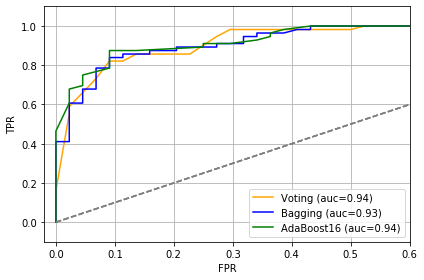

In [25]:
clf_labels =['Voting', 'Bagging', 'AdaBoost16']
colors = ['orange', 'blue', 'green']
linestyles = ['-', '-', '-']
for clf, label, clr, ls in zip([best_vt, bag, ada16], clf_labels, colors, linestyles):
    # assume positive class is at dimension 2
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc=%0.2f)' % (label, roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlim([-0.02, 0.6])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
plt.grid()
plt.tight_layout()
plt.savefig('./output/fig-ensemble-roc.png', dpi=300)
plt.show()

# <center>Assignment</center>
In this assignment, a dataset called Playground dataset will be used. This data includes four competitors and their (x, y) coordinations while they doing some exercise in the playground. The dataset can be downloaded <a href="https://github.com/nthu-datalab/ml/tree/master/labs/08_CV_Ensembling/CV_playground_dataset">here</a>.<br>

## Goal
Train models using any methods you have learned so far to achieve best accuracy on the testing data. You can plot the train.csv and try to ensemble models that performs well on different competitors<br>

## Read this note carefully
- Submit to iLMS with your code file ```Lab08_{student_id}.ipynb```. The notebook should contain
    1. Your code and accuracy by all the models you have tried, which will at least include voting, bagging, and boosting models
    2. Use Gridsearch to fine-tune your results. In particular, for base learner of adaboost, we hope you can try decision stump (decision tree with depth 1) and decision tree with higher depths
    3. Try to evaluate and summarize the results
- Deadline: **2021-11-2(Tue) 23:59**
- Please make sure that we can rerun your code
- Please keep all the models you have tried in your ipynb

The following is example code to load and plot the training data

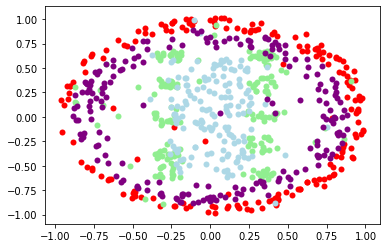

In [26]:
file = open('./train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
    i += 1
    X = np.vstack((X, np.array(row[0:2])))
    y = np.append(y, y_mapping[row[2]])
X = X.astype(np.float)
y = y.astype(np.float)
file.close()

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X[y == 2, 0], X[y == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X[y == 3, 0], X[y == 3, 1], label='Sue', c='purple', linewidths=0)